## Bayesian Optimisation Verification

In [3]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error
# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
# Setup data for training and evaluation
X_ = np.linspace(0,5000, 5000)
# import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df_time = X_
# import data sheet at 85 C (time:0~5000s) 
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
# df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
# df_85s = df.values.tolist()
# Format date into numpy array format
y_normal = np.array(df_85).T 
y_normal = y_normal.reshape((5000))
x_normal = X_
# x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

In [5]:
def ucb(X , gp, dim, delta):
	"""
	Calculates the GP-UCB acquisition function values
	Inputs: gp: The Gaussian process, also contains all data
		x:The point at which to evaluate the acquisition function 
	Output: acq_value: The value of the aquisition function at point x
	"""
	mean, var = gp.predict(X[:, np.newaxis], return_cov=True)
	mean = np.atleast_2d(mean).T
	var = np.atleast_2d(var).T  
	beta = 2*np.log(np.power(5000,2.1)*np.square(np.pi)/(3*delta))
	return mean - np.sqrt(beta)* np.sqrt(np.diag(var))

In [23]:
# Plot function to show performance of gp prediction
def plot_performance(list_NOISE_LEVEL,performance_parameter):
    plt.figure()
    plt.plot(list_NOISE_LEVEL, performance_parameter, c='blue', lw=2, zorder=3)
    plt.scatter(list_NOISE_LEVEL, performance_parameter, c='red', s=10, zorder=4)
    # plt.xscale('log')
    plt.tick_params(axis='y')
    plt.tick_params(axis='x')
    plt.ylabel('Performance parameter')
    plt.xlabel('Number of data points')
    # plt.ylim(0,0.00001)
    # plt.title('Performance of gp',color ='white')
    plt.tight_layout()
    plt.show()

In [7]:
def plot_UCB (X_,y_normal,X,y_mean, sigma,gp):
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)
    y_ucb = ucb(X_,gp,0.1,5)
    y_ucb = y_ucb.reshape(5000)
    plt.figure()
    plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
    plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
    plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                        alpha=0.5,color='grey',zorder=2, label='95% confidence interval')
    plt.scatter(X_,y_normal,c='lightblue',s=1,zorder=1, label='Experiment data')
    plt.scatter(X_,y_ucb,c='lightgreen',s=1,zorder=5, label='UCB')
    plt.scatter(np.argmin(y_ucb),y_ucb.min(),c='green',s=10,zorder=6,label = 'UCB minimum point')
    plt.tick_params(axis='y')
    plt.tick_params(axis='x')
    plt.ylabel('Lifetime')
    plt.xlabel('Time')
    plt.title("Number of data points: %s\nLog marginal likelihood: %s" % 
                (X.size,gp.log_marginal_likelihood(gp.kernel_.theta)))
    plt.legend()
    plt.tight_layout()
    # plt.savefig('BO_plot.jpg',dpi=600,format='jpg')
    plt.show()

In [10]:
# Plot function to show confidence bounds 
def plot(X_,y_normal,X,y_mean, sigma,gp):
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)
    plt.figure()
    plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
    plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
    plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                        alpha=0.5,color='grey',zorder=2, label='95% confidence interval')
    plt.plot(X_,y_normal,c='lightblue',lw=1,zorder=1, label='Experiment data')

    plt.tick_params(axis='y')
    plt.tick_params(axis='x')
    plt.ylabel('Lifetime')
    plt.xlabel('Time')
    plt.title("Number of data points: %s\nLog marginal likelihood: %s" % 
                (X.size,gp.log_marginal_likelihood(gp.kernel_.theta)))
    plt.legend()
    plt.tight_layout()
    plt.show()


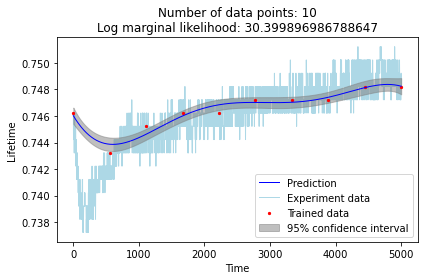

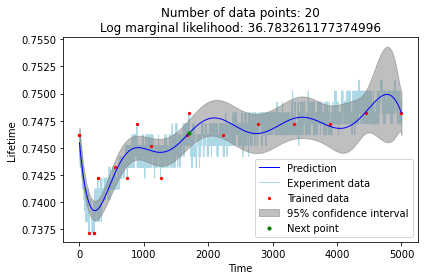

Excessive mse at 23 points = 0.00029640991728207004


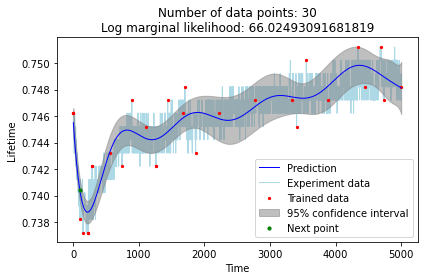

Excessive mse at 34 points = 3.8375853793768864e-05


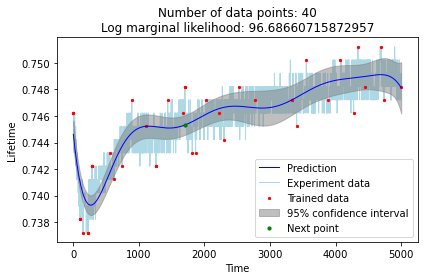

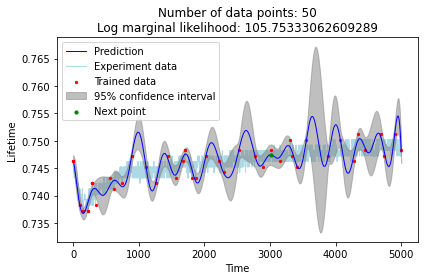


Mean squared error


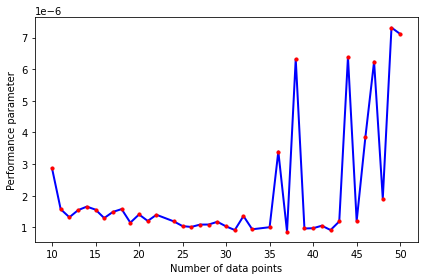

Log marginal likelihood


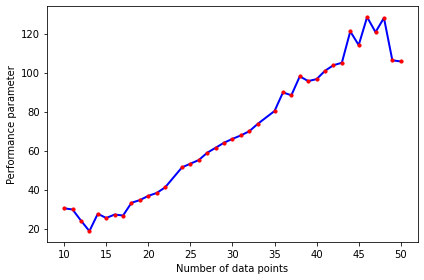

In [47]:
##### Testing for adding data by 
# the distance between prediction and experiment data
### User parameters settings
# START with this number of data points:
NUM_OF_DATA_POINTS = 10
# ADD this number of data points:
NUM_OF_EXTRA_DATA = 40
# max mse before remove it from final graph
MAX_mse_allowed = 1e-5
# gp settings 
NOISE_LEVEL = 10e-20
length_scale_bounds_MAX = 10e4
length_scale_bounds_MIN = 10e-10

### Initial data initialization
# (either evenly spread OR randomly chosen)
## 1. Have data points evenly spread
X = np.arange(0,4998,5000/(NUM_OF_DATA_POINTS-1)).astype(int)
X = np.append(4999,X)
## 2. Randomly chosed data points
# X = np.random.randint(5000, size=NUM_OF_DATA_POINTS)
##
# Formating data
X = X.reshape(X.size,1)
Y = y_normal[X]
# Set up performance parameters set
list_DATA_POINTS = np.array([])
list_mse = np.array([])
list_lml = np.array([])
# Kernel setting and prediction
kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 10e-4))
gp = GaussianProcessRegressor(kernel=kernel,alpha=10e-8).fit(X, Y)
y_mean, sigma = gp.predict(X_[:, np.newaxis],  return_std=True)
plot(X_,y_normal,X,y_mean, sigma,gp)
# Collect mse and lml infomation
mse = mean_squared_error(y_normal,y_mean)
lml = gp.log_marginal_likelihood(gp.kernel_.theta)
list_DATA_POINTS = np.append(list_DATA_POINTS,X.size)
list_mse = np.append(list_mse,mse)
list_lml = np.append(list_lml,lml)

### loop to find next data point automatically by the desired way
for i in range(NUM_OF_EXTRA_DATA):
    ### followings are a few different ways to choose next point 
    ###(uncomment the one you want and comment the others to work)
    ## 1. by picking lowest UCB value
    # y_ucb = ucb(X_,gp,0.1,5)
    # y_ucb = y_ucb.reshape(5000)
    # X_next =np.argmin(y_ucb)
    # kernel_alpha = 5e-7

    ## 2. by the biggest distance between prediction adn experiment data
    y_mean = y_mean.reshape(5000)
    y_distance = np.absolute(y_mean-y_normal)
    y_distance = y_distance.reshape(5000)
    X_next = np.argmax(y_distance)
    kernel_alpha = 1e-6

    ## 3. by picking the minimum prediction value
    ## (if the value has already used in model training, go to next one til not repeated)
    # y_mean = y_mean.reshape(5000)
    # X_next = np.argmin(y_mean)
    # while X_next in X:
    #     X_next +=1
    # kernel_alpha = 1e-8

    ##
    X = np.append(X,X_next)
    X.sort()
    X=X.reshape(X.size,1)
    Y = y_normal[X]

    # Kernel setting and prediction
    kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 10e-4))
    gp = GaussianProcessRegressor(kernel=kernel,alpha=kernel_alpha).fit(X, Y)
    y_mean, sigma = gp.predict(X_[:, np.newaxis],  return_std=True)
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)

    # Collect mse and lml infomation
    mse = mean_squared_error(y_normal,y_mean)
    lml = gp.log_marginal_likelihood(gp.kernel_.theta)
    # Prevent not fitting model from creating outliers
    if mse < MAX_mse_allowed:
        list_DATA_POINTS = np.append(list_DATA_POINTS,X.size)
        list_mse = np.append(list_mse,mse)
        list_lml = np.append(list_lml,lml)
    else:
        print('Excessive mse at %s points = %s' %(X.size,mse))
    # plot prediction graph in every 10 iterations
    if (X.size)%10 == 0:
        plt.figure()
        plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
        plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
        plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                            alpha=0.5,color='grey',zorder=2, label='95% confidence interval')
        plt.plot(X_,y_normal,c='lightblue',lw=1,zorder=1, label='Experiment data')
        plt.scatter(X_next,y_mean[X_next],c='green', s=10,zorder=6,label = 'Next point')
        plt.tick_params(axis='y')
        plt.tick_params(axis='x')
        plt.ylabel('Lifetime')
        plt.xlabel('Time')
        plt.title("Number of data points: %s\nLog marginal likelihood: %s" % 
                    (X.size,gp.log_marginal_likelihood(gp.kernel_.theta)))
        plt.legend()
        plt.tight_layout()
        # plt.savefig('BO_plot.jpg',dpi=600,format='jpg')
        plt.show()

# plot relevant graphs
print('\nMean squared error')
plot_performance(list_DATA_POINTS,list_mse)
print('Log marginal likelihood')
plot_performance(list_DATA_POINTS,list_lml)